In [1]:
# # clone the respective repository
!git clone https://github.com/sathishkumar67/Feature-Fusion.git

# move the files to the current directory
!mv /kaggle/working/Feature-Fusion/* /kaggle/working/ # replace /content/ in the place of /kaggle/working/ if you are using Google Colab

# upgrade pip
!pip install --upgrade pip

# install the required packages
!pip install -r requirements.txt

Cloning into 'Feature-Fusion'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 7), reused 15 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 51.90 KiB | 4.33 MiB/s, done.
Resolving deltas: 100% (7/7), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# import os
# import shutil

# # Get the current working directory
# current_path = os.getcwd()

# # Loop through all items in the directory
# for item in os.listdir(current_path):
#     item_path = os.path.join(current_path, item)

#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.remove(item_path)  # Remove files and symbolic links
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)  # Remove directories
#     except Exception as e:
#         print(f"Failed to delete {item_path}. Reason: {e}")

In [2]:
# Import necessary libraries
import os
import time
import joblib
import optuna
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import huggingface_hub as hf

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M, MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

from utils import unzip_file
# Suppress warnings
warnings.filterwarnings("ignore")

# set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

2025-06-18 14:22:53.434247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750256573.656166      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750256573.717174      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set Constants
REPO_ID = "pt-sk/cashew_augmented"
REPO_TYPE = "dataset"
FILENAME_IN_REPO = ["Cashew_Augmented.zip", "fused_train_features.npy", "fused_val_features.npy", "train_labels_indices.npy", "val_labels_indices.npy"]
LOCAL_DIR = os.getcwd()
DATASET_PATH = f"{LOCAL_DIR}/{FILENAME_IN_REPO[0]}"  # Path to the downloaded dataset zip file

# Download the dataset from Hugging Face
for filename in FILENAME_IN_REPO:
    # Download each file from the repository
    hf.hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type=REPO_TYPE, local_dir=LOCAL_DIR)

# Unzip the Downloaded File
unzip_file(DATASET_PATH, LOCAL_DIR)

Cashew_Augmented.zip:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

fused_train_features.npy:   0%|          | 0.00/112M [00:00<?, ?B/s]

fused_val_features.npy:   0%|          | 0.00/28.1M [00:00<?, ?B/s]

train_labels_indices.npy:   0%|          | 0.00/121k [00:00<?, ?B/s]

val_labels_indices.npy:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

Unzipping: 100%|██████████| 1.34G/1.34G [00:08<00:00, 154MB/s]


Unzipped /kaggle/working/Cashew_Augmented.zip to /kaggle/working
Removed zip file: /kaggle/working/Cashew_Augmented.zip


In [8]:
# # Define dataset paths and parameters
# ImagePath = f'{LOCAL_DIR}/CashewTr'
# img_height = 224
# img_width = 224
# batch_size = 64 # Adjust batch size as needed

# # Load the dataset for training and validation
# # Create training from the directory
# train_ds = image_dataset_from_directory(
#     ImagePath,
#     labels='inferred',
#     label_mode='categorical',
#     image_size=(img_height, img_width),
#     validation_split=0.2,
#     subset='training',
#     seed=seed,
#     batch_size=batch_size
# )

# # Create validation dataset from the directory
# val_ds = image_dataset_from_directory(
#     ImagePath,
#     labels='inferred',
#     label_mode='categorical',
#     image_size=(img_height, img_width),
#     validation_split=0.2,
#     subset='validation',
#     seed=seed,
#     batch_size=batch_size
# )

# # Print class names and number of classes
# class_names = train_ds.class_names
# num_classes = len(class_names)
# print("Class names:", class_names)
# print("Number of classes:", num_classes)

# # Function to extract features from a pretrained model
# def feature_extractor(model, preprocess_function):
#     input_tensor = Input(shape=(img_height, img_width, 3))
#     processed_input = preprocess_function(input_tensor)
#     output_tensor = model(processed_input)
#     pooled_output = GlobalAveragePooling2D()(output_tensor)
#     feature_model = Model(inputs=input_tensor, outputs=pooled_output)
#     return feature_model

# # Load pretrained models
# efficientnet_base = EfficientNetV2M(include_top=False, weights='imagenet')
# mobilenet_base = MobileNetV3Small(include_top=False, weights='imagenet')

# # Freeze the base layers
# for layer in efficientnet_base.layers:
#     layer.trainable = False
# for layer in mobilenet_base.layers:
#     layer.trainable = False
    
# # Function to extract features from the dataset
# def extract_features_from_dataset(dataset, extractor):
#     all_features = []
#     all_labels = []
#     for images, labels in dataset:
#         features = extractor.predict(images)
#         all_features.append(features)
#         all_labels.append(labels.numpy())
#     return np.concatenate(all_features), np.concatenate(all_labels)

# # Create feature extraction models
# efficientnet_extractor = feature_extractor(efficientnet_base, tf.keras.applications.efficientnet_v2.preprocess_input)
# mobilenet_extractor = feature_extractor(mobilenet_base, tf.keras.applications.mobilenet_v3.preprocess_input)

# # Extract features
# print("Extracting EfficientNetV2M features...")
# efficientnet_train_features, train_labels = extract_features_from_dataset(train_ds, efficientnet_extractor)
# efficientnet_val_features, val_labels = extract_features_from_dataset(val_ds, efficientnet_extractor)

# print("Extracting MobileNetV3Small features...")
# mobilenet_train_features, _ = extract_features_from_dataset(train_ds, mobilenet_extractor)
# mobilenet_val_features, _ = extract_features_from_dataset(val_ds, mobilenet_extractor)

# # Fuse features by concatenation
# fused_train_features = np.concatenate([efficientnet_train_features, mobilenet_train_features], axis=1)
# fused_val_features = np.concatenate([efficientnet_val_features, mobilenet_val_features], axis=1)

# # Convert one-hot encoded labels to class indices
# train_labels_indices = np.argmax(train_labels, axis=1)
# val_labels_indices = np.argmax(val_labels, axis=1)

In [10]:
# load the fused features and labels
fused_train_features = np.load('fused_train_features.npy')
fused_val_features = np.load('fused_val_features.npy')
train_labels_indices = np.load('train_labels_indices.npy')
val_labels_indices = np.load('val_labels_indices.npy')

# get the no of classes and class names
num_classes = 5
class_names = ['anthracnose', 'gumosis', 'healthy', 'leaf miner', 'red rust']

print("Number of classes:", num_classes)
print("Class names:", class_names)

# variables for results
results = {
    'Model': [],
    'Accuracy': [],
    'F1_Score': [],
    'Precision': [],
    'Recall/TPR': [],
    'ROC_AUC': [],
    'FPR': [],
    "Training Time": [],
    "Validation Time": [],
}

Number of classes: 5
Class names: ['anthracnose', 'gumosis', 'healthy', 'leaf miner', 'red rust']


In [11]:
# --- Untuned XGBoost ---
print("\n--- Untuned XGBoost ---")
untuned_xgb_model = XGBClassifier(device="cuda", objective='multi:softmax', num_class=num_classes, random_state=seed) # training on GPU

start_time = time.time()
# Fit the model on the fused training features
untuned_xgb_model.fit(fused_train_features, train_labels_indices, verbose=1)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# add training time to results
results['Model'].append('XGBoost (Untuned)')
results['Training Time'].append(round(train_time, 2))


--- Untuned XGBoost ---
Training time: 8.40 seconds


Untuned XGBoost Accuracy: 0.9220
Untuned XGBoost Precision: 0.9211
Untuned XGBoost Recall: 0.9220
Untuned XGBoost F1-Score: 0.9210
Untuned XGBoost ROC AUC: 0.9909
Untuned XGBoost FPR: 0.0204
Untuned XGBoost Classification Report:
              precision    recall  f1-score   support

 anthracnose       0.86      0.79      0.83       601
     gumosis       0.99      0.99      0.99       359
     healthy       0.92      0.98      0.95      1166
  leaf miner       0.91      0.87      0.89       709
    red rust       0.94      0.95      0.95       947

    accuracy                           0.92      3782
   macro avg       0.92      0.92      0.92      3782
weighted avg       0.92      0.92      0.92      3782

Evaluation time: 0.22 seconds


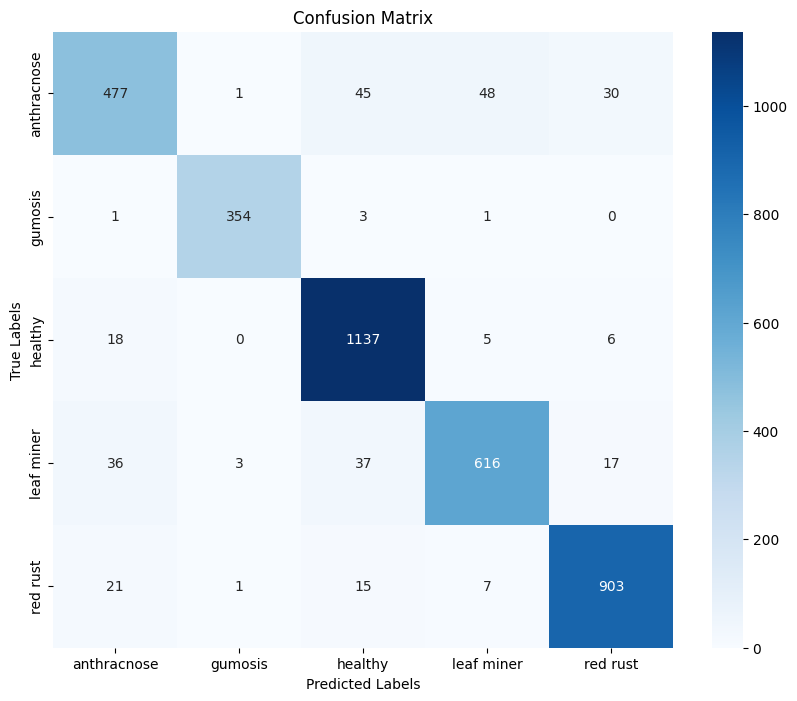

In [12]:
# evaluate untuned XGBoost model on validation set
start_time = time.time()
untuned_xgb_model.set_params(predictor='cpu_predictor') # switch to CPU predictor
untuned_xgb_predictions = untuned_xgb_model.predict(fused_val_features)
untuned_xgb_accuracy = accuracy_score(val_labels_indices, untuned_xgb_predictions)
untuned_xgb_precision = precision_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_recall = recall_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_f1 = f1_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_roc_auc = roc_auc_score(val_labels_indices, untuned_xgb_model.predict_proba(fused_val_features), multi_class='ovr')

# compute per-class fprs
fprs = []
for i in range(num_classes):
    y_true_i = (val_labels_indices == i).astype(int)
    y_pred_i = (untuned_xgb_predictions == i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_i, y_pred_i).ravel()
    fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fprs.append(fpr_i)

# Macro‑average FPR
untuned_xgb_fpr = np.mean(fprs)

# Print results
print(f"Untuned XGBoost Accuracy: {untuned_xgb_accuracy:.4f}")
print(f"Untuned XGBoost Precision: {untuned_xgb_precision:.4f}")
print(f"Untuned XGBoost Recall: {untuned_xgb_recall:.4f}")
print(f"Untuned XGBoost F1-Score: {untuned_xgb_f1:.4f}")
print(f"Untuned XGBoost ROC AUC: {untuned_xgb_roc_auc:.4f}")
print(f"Untuned XGBoost FPR: {untuned_xgb_fpr:.4f}")
print("Untuned XGBoost Classification Report:")
print(classification_report(val_labels_indices, untuned_xgb_predictions, target_names=class_names))
end_time = time.time()
print(f"Evaluation time: {end_time - start_time:.2f} seconds")

# add evaluation metrics to results
results['Accuracy'].append(round(untuned_xgb_accuracy, 4))
results['F1_Score'].append(round(untuned_xgb_f1, 4))
results['Precision'].append(round(untuned_xgb_precision, 4))
results['Recall/TPR'].append(round(untuned_xgb_recall, 4))
results['ROC_AUC'].append(round(untuned_xgb_roc_auc, 4))
results['FPR'].append(round(untuned_xgb_fpr, 4))
results['Validation Time'].append(round(end_time - start_time, 2))

# Generate confusion matrix
cm = confusion_matrix(val_labels_indices, untuned_xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# XGBoost Hyperparameter Tuning with BOHB
def objective(trial):
    # Define hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=50)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20, step=1)
    subsample = trial.suggest_float('subsample', 0.2, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1.0)

    # Create XGBoost model
    xgb_model = XGBClassifier(n_estimators=n_estimators, 
                            learning_rate=learning_rate, 
                            max_depth=max_depth,
                            subsample=subsample, 
                            colsample_bytree=colsample_bytree, 
                            objective='multi:softmax',
                            num_class=num_classes, 
                            random_state=seed,
                            device="cuda")  # training on GPU

    # Train XGBoost model
    xgb_model.fit(fused_train_features, 
                train_labels_indices, verbose=1)
    
    # Set the predictor to CPU for evaluation
    xgb_model.set_params(predictor='cpu_predictor')
    
    # Evaluate XGBoost model
    y_pred = xgb_model.predict(fused_val_features)
    accuracy = accuracy_score(val_labels_indices, y_pred)
    
    # return accuracy for bohb
    return accuracy

# Define the number of trials to run
NUM_TRIALS = 50

# create study
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=seed),
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name="xgboost_hyperparameter_tunning",
                            load_if_exists=True)

# optimize best parameters
start_time = time.time()
study.optimize(objective, n_trials=NUM_TRIALS)
end_time = time.time()
print(f"Tuning time: {end_time - start_time:.2f} seconds")

# Get the best trial
best_trial = study.best_trial
print("\n--- Best Trial ---")
print(f"Value (Accuracy): {best_trial.value:.4f}")
print("Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# save study
joblib.dump(study, f"{LOCAL_DIR}/xgboost_study.pkl")

[I 2025-06-18 14:34:00,670] A new study created in memory with name: xgboost_hyperparameter_tunning
[I 2025-06-18 14:34:14,571] Trial 0 finished with value: 0.9122157588577472 and parameters: {'n_estimators': 150, 'learning_rate': 0.6351221010640696, 'max_depth': 16, 'subsample': 0.6789267873576292, 'colsample_bytree': 0.3248149123539492}. Best is trial 0 with value: 0.9122157588577472.
[I 2025-06-18 14:34:58,409] Trial 1 finished with value: 0.8778424114225277 and parameters: {'n_estimators': 100, 'learning_rate': 0.0001707396743152812, 'max_depth': 18, 'subsample': 0.6808920093945671, 'colsample_bytree': 0.7664580622368364}. Best is trial 0 with value: 0.9122157588577472.
[I 2025-06-18 14:35:09,804] Trial 2 finished with value: 0.8974087784241143 and parameters: {'n_estimators': 100, 'learning_rate': 0.7579479953348001, 'max_depth': 17, 'subsample': 0.36987128854262097, 'colsample_bytree': 0.3454599737656805}. Best is trial 0 with value: 0.9122157588577472.
[I 2025-06-18 14:35:38,303

In [ ]:
# selecting the best hyperparameter values
n_estimators = study.best_params['n_estimators']
learning_rate = study.best_params['learning_rate']
max_depth = study.best_params['max_depth']
subsample = study.best_params['subsample']
colsample_bytree = study.best_params['colsample_bytree']

# Create XGBoost model
xgb_model_tunned = XGBClassifier(n_estimators=n_estimators, 
                                learning_rate=learning_rate, 
                                max_depth=max_depth,
                                subsample=subsample, 
                                colsample_bytree=colsample_bytree, 
                                objective='multi:softmax',
                                num_class=num_classes, 
                                random_state=seed, 
                                device="cuda")

start_time = time.time()
# Train XGBoost model
xgb_model_tunned.fit(fused_train_features, train_labels_indices)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# set predictor to CPU
xgb_model_tunned.set_params(predictor='cpu_predictor')

# Evaluate XGBoost model
y_pred = xgb_model_tunned.predict(fused_val_features)
accuracy = accuracy_score(val_labels_indices, y_pred)
precision = precision_score(val_labels_indices, y_pred, average='weighted')
recall = recall_score(val_labels_indices, y_pred, average='weighted')
f1 = f1_score(val_labels_indices, y_pred, average='weighted')
roc_auc = roc_auc_score(val_labels_indices, xgb_model_tunned.predict_proba(fused_val_features), multi_class='ovr')

# compute per-class fprs
fprs = []
for i in range(num_classes):
    y_true_i = (val_labels_indices == i).astype(int)
    y_pred_i = (y_pred == i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_i, y_pred_i).ravel()
    fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fprs.append(fpr_i)
    
# Macro‑average FPR
fpr = np.mean(fprs)

print(f"Best XGBoost Parameters: {study.best_params}")
print(f"Tuned XGBoost Accuracy: {accuracy:.4f}")
print(f"Tuned XGBoost Precision: {precision:.4f}")
print(f"Tuned XGBoost Recall: {recall:.4f}")
print(f"Tuned XGBoost F1-Score: {f1:.4f}")
print(f"Tuned XGBoost ROC AUC: {roc_auc:.4f}")
print(f"Tuned XGBoost FPR: {fpr:.4f}")
print("Tuned XGBoost Classification Report:")
print(classification_report(val_labels_indices, y_pred, target_names=class_names))

# # Generate confusion matrix
cm = confusion_matrix(val_labels_indices, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()